In [1]:
import os
import numpy as np
import librosa
import pandas as pd
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm
from scipy.io import wavfile
from sklearn.model_selection import cross_val_score

def calculate_metrics(target, prediction, average='weighted'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]*100:.4f} %')
    print(f'  Precision: {metrics[1]*100:.4f} %')
    print(f'  Recall:    {metrics[2]*100:.4f} %')
    print(f'  F1 score:  {metrics[3]*100:.4f} %')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def print_min_max(collumn):
    print(f'  Maksimum:  {collumn.max():.4f}')
    print(f'  Minimum:   {collumn.min():.4f}')
    print(f'  Średnia:   {collumn.mean():.4f}')
    print(f'  Mediana:   {collumn.median():.4f}')
    
def Model_poza(My_model,plik_csv):
    final_poza = pd.DataFrame()
    Thatistrue_poza = pd.DataFrame()
    for file in plik_csv['Name'].unique():
        One_person_poza = plik_csv.loc[plik_csv['Name'] == file].drop('Name', axis = 1)
        One_person_poza = scaler_standard.transform(One_person_poza)

        Prediction_poza = My_model.predict(One_person_poza) #tutaj zamieniamy knn na inny model do predykcji

        # Obliczanie na ile osoba sprawdzana jest podobna do samej siebie
        df11_poza = pd.DataFrame(Prediction_poza,columns = ['Ho'])
        df = pd.DataFrame({'Name': file},index=[0])
        final_poza = pd.concat([final_poza, df]).reset_index(drop=True)

        # Obliczanie do kogo osoba sprawdzana jest najbardziej podobna
        hois = df11_poza.value_counts().idxmax()[0]
        howmuch = df11_poza.value_counts(normalize=True).max()*100
        datahow = pd.DataFrame({'Similar to': hois, 'How much [%]': howmuch}, index=[0])
        Thatistrue_poza = pd.concat([Thatistrue_poza, datahow]).reset_index(drop=True)
        #złączenie tabel
        final_form_poza = pd.concat([final_poza,Thatistrue_poza],axis=1)

    display(final_form_poza)
    print_min_max(final_form_poza['How much [%]'])
    
def Model_odtwarzanie(My_model,plik_csv):
    final = pd.DataFrame()
    Thatistrue = pd.DataFrame()
    for file in plik_csv['Name'].unique():
        One_person = plik_csv.loc[plik_csv['Name'] == file].drop('Name', axis = 1)
        One_person = scaler_standard.transform(One_person)

        Prediction = My_model.predict(One_person) #tutaj zamieniamy knn na inny model do predykcji

        # Obliczanie na ile osoba sprawdzana jest podobna do samej siebie
        df11 = pd.DataFrame(Prediction,columns = ['Ho'])
        df_True = df11[df11["Ho"]  == file]
        probability = df_True.size/df11.size*100
        df = pd.DataFrame({'Name': file, 'To himself [%]': probability}, index=[0])
        final = pd.concat([final, df]).reset_index(drop=True)

        # Obliczanie do kogo osoba sprawdzana jest najbardziej podobna
        hois = df11.value_counts().idxmax()[0]
        howmuch = df11.value_counts(normalize=True).max()*100
        datahow = pd.DataFrame({'Similar to': hois, 'How much [%]': howmuch}, index=[0])
        Thatistrue = pd.concat([Thatistrue, datahow]).reset_index(drop=True)
        #złączenie tabel
        final_form = pd.concat([final,Thatistrue],axis=1)
        final_form['Is the same person'] = (final_form['Name'] == final_form['Similar to'])
        final_form['More than >80%'] = (final_form['How much [%]'] >= 80)

    display(final_form) 
    print_min_max(final_form['To himself [%]'])
    

def Model_test(My_model,X_test_my,y_test_my, pred,plik_csv,scaler):
    print_results(calculate_metrics(y_test_my, pred))
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(My_model, X_test_my, y_test_my,ax=ax,xticks_rotation= 'vertical')
    plt.title('Confusion matrix')
    plt.show()
    final_test = pd.DataFrame()
    Thatistrue = pd.DataFrame()
    for file in plik_csv['Name'].unique():
        One_person = plik_csv.loc[plik_csv['Name'] == file].drop('Name', axis = 1)
        One_person = scaler.transform(One_person)

        Prediction = My_model.predict(One_person) #tutaj zamieniamy knn na inny model do predykcji

        # Obliczanie na ile osoba sprawdzana jest podobna do samej siebie
        df11 = pd.DataFrame(Prediction,columns = ['Ho'])
        df_True = df11[df11["Ho"]  == file]
        probability = df_True.size/df11.size*100
        df = pd.DataFrame({'Name': file, 'To himself [%]': probability}, index=[0])
        final_test = pd.concat([final_test, df]).reset_index(drop=True)


        # Obliczanie do kogo osoba sprawdzana jest najbardziej podobna
        hois = df11.value_counts().idxmax()[0]
        howmuch = df11.value_counts(normalize=True).max()*100
        datahow = pd.DataFrame({'Similar to': hois, 'How much [%]': howmuch}, index=[0])
        Thatistrue = pd.concat([Thatistrue, datahow]).reset_index(drop=True)
        #złączenie tabel
        final_form = pd.concat([final_test, Thatistrue],axis=1)

    display(final_form) 
    print_min_max(final_form['To himself [%]'])
    
def obrobka_mfcc(path, save):
    final = pd.DataFrame()
    file_list =  os.listdir(path)
    for file in file_list:
        (sr, y) = wavfile.read(path + file) 
        y = y * (1 / np.max(np.abs(y)) )
        clips = librosa.effects.split(y, top_db=20)
        wav_data = []
        for c in clips:
            data = y[c[0]: c[1]]
            wav_data.extend(data)
        mfcc_feat = mfcc(np.array(wav_data), sr,winlen=winlen,winstep=winstep,numcep=numcep,nfilt=nfilt,nfft=nfft,lowfreq=lowfreq,preemph=preemph, ceplifter = ceplifter,appendEnergy=appendEnergy,winfunc=winfunc)
        df_mfcc_feat = pd.DataFrame(mfcc_feat)
        df_mfcc_feat['Name'] = file
        final = pd.concat([final, df_mfcc_feat])
    final.reset_index(drop=True)
    final.to_csv(save+'.csv', index=False)

# Obróbka i wyciąganie cech z plików Audio wraz z zapisem do CSV

In [2]:
winlen = 0.12
winstep = winlen/2
numcep = 22
nfilt = 26
nfft = int(2**14)
lowfreq = 0
preemph = 0.097
appendEnergy = False
ceplifter = 22
winfunc = np.hamming

In [3]:
path_train = "Inz\\obrobka\\"
path_test = "Inz\\test\\"
path_poza = "Inz\\poza\\"
obrobka_mfcc(path_train,"Trenujacy")
obrobka_mfcc(path_test,"Walidacyjny")

# Wczytanie danych z CSV

In [4]:
Final_training = pd.read_csv('Trenujacy.csv')
Final_test = pd.read_csv('Walidacyjny.csv')

# Podział danych

In [5]:
y = Final_training['Name']
x = Final_training.drop('Name', axis = 1)
scaler_standard = StandardScaler()
x = scaler_standard.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y,test_size=0.2,random_state= 3113)

# Regresja logistyczna

Results for classifier
----
  Accuracy:  96.9572 %
  Precision: 96.9738 %
  Recall:    96.9572 %
  F1 score:  96.9592 %
  Mislabeled 59 out of 1939




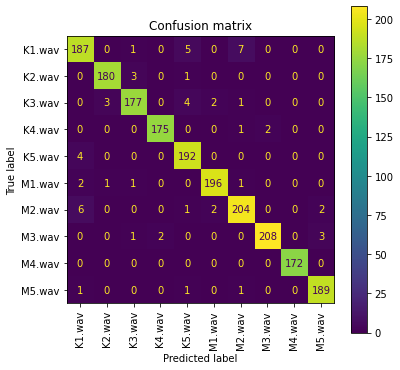

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,81.578947,K1.wav,81.578947
1,K2.wav,93.023256,K2.wav,93.023256
2,K3.wav,87.755102,K3.wav,87.755102
3,K4.wav,97.872340,K4.wav,97.872340
4,K5.wav,90.909091,K5.wav,90.909091
5,M1.wav,91.071429,M1.wav,91.071429
6,M2.wav,66.666667,M2.wav,66.666667
7,M3.wav,85.294118,M3.wav,85.294118
8,M4.wav,80.645161,M4.wav,80.645161
9,M5.wav,87.878788,M5.wav,87.878788


  Maksimum:  97.8723
  Minimum:   66.6667
  Średnia:   86.2695
  Mediana:   87.8169


In [6]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(solver='lbfgs', max_iter=200, C=0.7,multi_class='multinomial')
logreg_clf.fit(X_train,y_train)
pred_logreg = logreg_clf.predict(X_test)
Model_test(logreg_clf,X_test,y_test, pred_logreg,Final_test,scaler_standard)

# KNN

Results for classifier
----
  Accuracy:  97.1635 %
  Precision: 97.2464 %
  Recall:    97.1635 %
  F1 score:  97.1727 %
  Mislabeled 55 out of 1939




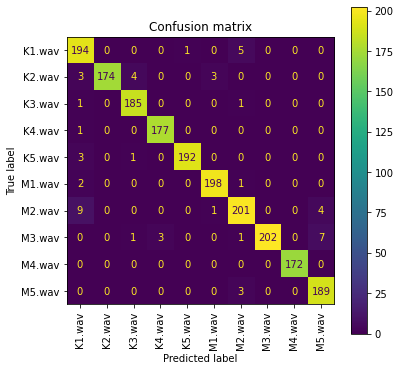

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,84.210526,K1.wav,84.210526
1,K2.wav,90.697674,K2.wav,90.697674
2,K3.wav,93.877551,K3.wav,93.877551
3,K4.wav,82.978723,K4.wav,82.978723
4,K5.wav,100.000000,K5.wav,100.000000
5,M1.wav,94.642857,M1.wav,94.642857
6,M2.wav,92.307692,M2.wav,92.307692
7,M3.wav,97.058824,M3.wav,97.058824
8,M4.wav,93.548387,M4.wav,93.548387
9,M5.wav,84.848485,M5.wav,84.848485


  Maksimum:  100.0000
  Minimum:   82.9787
  Średnia:   91.4171
  Mediana:   92.9280


In [7]:
knn = KNeighborsClassifier(n_neighbors =3,weights="distance", metric = "euclidean")
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
Model_test(knn,X_test,y_test, pred_knn,Final_test,scaler_standard)

# SVM

Results for classifier
----
  Accuracy:  97.3182 %
  Precision: 97.3315 %
  Recall:    97.3182 %
  F1 score:  97.3214 %
  Mislabeled 52 out of 1939




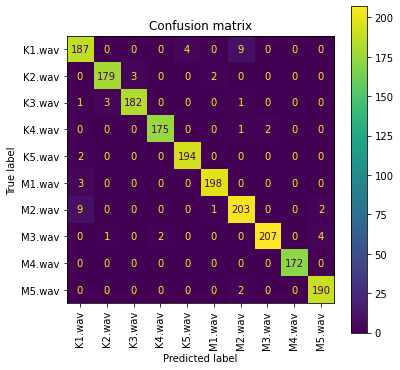

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,81.578947,K1.wav,81.578947
1,K2.wav,93.023256,K2.wav,93.023256
2,K3.wav,93.877551,K3.wav,93.877551
3,K4.wav,82.978723,K4.wav,82.978723
4,K5.wav,96.969697,K5.wav,96.969697
5,M1.wav,96.428571,M1.wav,96.428571
6,M2.wav,87.179487,M2.wav,87.179487
7,M3.wav,100.000000,M3.wav,100.000000
8,M4.wav,90.322581,M4.wav,90.322581
9,M5.wav,96.969697,M5.wav,96.969697


  Maksimum:  100.0000
  Minimum:   81.5789
  Średnia:   91.9329
  Mediana:   93.4504


In [8]:
svm_clf = svm.SVC(kernel='rbf',C = 0.2, gamma = 'auto') 
svm_clf.fit(X_train, y_train)
pred_SVM = svm_clf.predict(X_test)
Model_test(svm_clf,X_test,y_test,pred_SVM,Final_test,scaler_standard)

# Drzewo decyzyjne

Results for classifier
----
  Accuracy:  80.6086 %
  Precision: 80.8019 %
  Recall:    80.6086 %
  F1 score:  80.6714 %
  Mislabeled 376 out of 1939




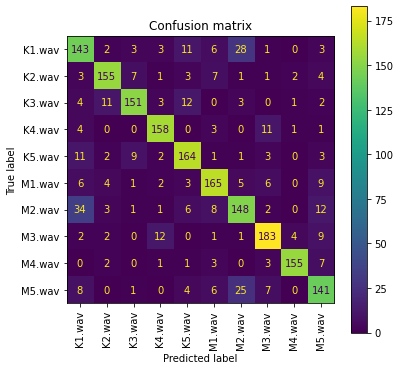

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,65.789474,K1.wav,65.789474
1,K2.wav,79.069767,K2.wav,79.069767
2,K3.wav,77.551020,K3.wav,77.551020
3,K4.wav,68.085106,K4.wav,68.085106
4,K5.wav,75.757576,K5.wav,75.757576
5,M1.wav,53.571429,M1.wav,53.571429
6,M2.wav,46.153846,M2.wav,46.153846
7,M3.wav,91.176471,M3.wav,91.176471
8,M4.wav,45.161290,M4.wav,45.161290
9,M5.wav,81.818182,M5.wav,81.818182


  Maksimum:  91.1765
  Minimum:   45.1613
  Średnia:   68.4134
  Mediana:   71.9213


In [9]:
from sklearn import tree
MyTree = tree.DecisionTreeClassifier(criterion = "entropy",splitter="best")
MyTree.fit(X_train, y_train)
pred_tree = MyTree.predict(X_test)
Model_test(MyTree,X_test,y_test,pred_tree,Final_test,scaler_standard)

# Lasy losowe

Results for classifier
----
  Accuracy:  95.1006 %
  Precision: 95.1211 %
  Recall:    95.1006 %
  F1 score:  95.1009 %
  Mislabeled 95 out of 1939




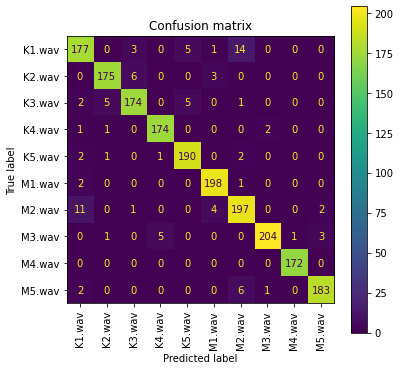

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,76.315789,K1.wav,76.315789
1,K2.wav,93.023256,K2.wav,93.023256
2,K3.wav,83.673469,K3.wav,83.673469
3,K4.wav,82.978723,K4.wav,82.978723
4,K5.wav,90.909091,K5.wav,90.909091
5,M1.wav,85.714286,M1.wav,85.714286
6,M2.wav,84.615385,M2.wav,84.615385
7,M3.wav,97.058824,M3.wav,97.058824
8,M4.wav,74.193548,M4.wav,74.193548
9,M5.wav,90.909091,M5.wav,90.909091


  Maksimum:  97.0588
  Minimum:   74.1935
  Średnia:   85.9391
  Mediana:   85.1648


In [10]:
from sklearn.ensemble import RandomForestClassifier
randomF = RandomForestClassifier(criterion="entropy",n_estimators=80)
randomF.fit(X_train, y_train)
pred_randomf = randomF.predict(X_test)
Model_test(randomF,X_test,y_test,pred_randomf,Final_test,scaler_standard)

# MLP

Results for classifier
----
  Accuracy:  95.1006 %
  Precision: 95.2572 %
  Recall:    95.1006 %
  F1 score:  95.1221 %
  Mislabeled 95 out of 1939




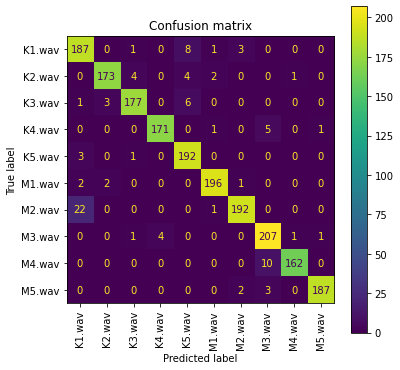

,Name,To himself [%],Similar to,How much [%]
0,K1.wav,94.736842,K1.wav,94.736842
1,K2.wav,86.046512,K2.wav,86.046512
2,K3.wav,77.551020,K3.wav,77.551020
3,K4.wav,93.617021,K4.wav,93.617021
4,K5.wav,93.939394,K5.wav,93.939394
5,M1.wav,91.071429,M1.wav,91.071429
6,M2.wav,82.051282,M2.wav,82.051282
7,M3.wav,94.117647,M3.wav,94.117647
8,M4.wav,74.193548,M4.wav,74.193548
9,M5.wav,93.939394,M5.wav,93.939394


  Maksimum:  94.7368
  Minimum:   74.1935
  Średnia:   88.1264
  Mediana:   92.3442


In [11]:
# Import MLPClassifer
from sklearn.neural_network import MLPClassifier
# Create model object
MLP = MLPClassifier(hidden_layer_sizes=(5,5),
                    activation = "relu",
                    random_state= 5,
                    verbose=False,
                    learning_rate_init=0.01)
# Fit data onto the model
MLP.fit(X_train,y_train)
# Make prediction on test dataset
ypred=MLP.predict(X_test)
Model_test(MLP,X_test,y_test,ypred,Final_test,scaler_standard)

### Wnioski

Z przeprowadzonych badań wynika, iż najwyższą skutecznością charakteryzują się klasyfikatory: KNN oraz SVM. Skuteczność obu nie odbiegała do siebie znacząco. Minimalne prawdopodobieństwo dla jednego oraz drugiego klasyfikatora zostało wskazane dla tej samej osoby K4 i osiągnęło wartość powyżej 80%. Dzięki temu możliwe jest zdefiniowanie progu przy którym system powinien przyznawać dostęp. Algorytmem o najniższej skuteczności okazało się być metoda drzewa decyzyjnego. Ze względu na swoją prostotę średnia skuteczność wyniosła tutaj 71,22%. Metody lasu losowego, MLP wraz z regresją logistyczną osiągnęły zbliżone wyniki nie licząc minimum oraz błędnych oznaczeń dla danych walidacyjnych, przy czym MLP osiągnął lepszy wynik w minimum a regresja w błędnie oznaczonych danych. W dalszych badaniach wykorzystano dwa najlepsze klasyfikatory ze względu na ich skuteczność oraz prostotę implementacji.

# Badania

W oparciu o wstępnie zaproponowaną koncepcję systemu weryfikacji przeprowadzono szereg badań eksploatacyjnych mających na celu ocenę zaproponowanego rozwiązania. Ocena jakości systemu została przeanalizowana z wyszczególnieniem 3 wariantów badań:
Wariant 1 - ocena odporności systemu na odtwarzane nagranie
Wariant 2 - próba weryfikacji osób z poza bazy
Wariant 3 – ocena wpływu dźwięków otoczenia na weryfikację


## Odporność systemu na odtwarzane nagranie

Pierwszy z analizowanych przypadków zakłada uzyskanie dostępu do systemu dla osoby niezarejestrowanej w bazie poprzez odtworzenie nagranego głosu osoby która fizycznie taki dostęp posiada. W celu sprawdzenia odporności systemu na takie warunki działania zostały odtworzone nagrania testowe osób wprowadzonych do bazy z telefonu komórkowego iPhone 12 oraz z głośników komputerowych Genesis Helium 600 i nagrane za pomocą mikrofonu zamieszczonego w kamerze internetowej Logitech C270. Dla każdej osoby zostało wykonane po pięć prób dla telefonu oraz głośników przy różnych ustawieniach odległości oraz głośności w celu otrzymania jak najwyższej skuteczności. Wyniki dla próbek cechujących się najwyższą skutecznością zostały umieszczone w końcowych wynikach

In [12]:
path_glosnik = "C:\\Users\\akadix\\Inz\\glosnik\\"
obrobka_mfcc(path_glosnik,"glosnik")
Final_glosnik = pd.read_csv('glosnik.csv')

path_telefon = "C:\\Users\\akadix\\Inz\\telefon\\"
obrobka_mfcc(path_telefon,"telefon")
Final_telefon = pd.read_csv('telefon.csv')

### KNN

### nagranie odtwarzane z głośnika

In [13]:
Model_odtwarzanie(knn,Final_glosnik)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,45.714286,K1.wav,45.714286,True,False
1,K2.wav,83.783784,K2.wav,83.783784,True,True
2,K3.wav,82.352941,K3.wav,82.352941,True,True
3,K4.wav,0.000000,K3.wav,43.902439,False,False
4,K5.wav,2.777778,K3.wav,33.333333,False,False
5,M1.wav,85.416667,M1.wav,85.416667,True,True
6,M2.wav,83.333333,M2.wav,83.333333,True,True
7,M3.wav,17.142857,M2.wav,22.857143,False,False
8,M4.wav,81.578947,M4.wav,81.578947,True,True
9,M5.wav,54.285714,M5.wav,54.285714,True,False


  Maksimum:  85.4167
  Minimum:   0.0000
  Średnia:   53.6386
  Mediana:   67.9323


### nagranie odtwarzane z telefonu

In [14]:
Model_odtwarzanie(knn,Final_telefon)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,37.500000,K1.wav,37.500000,True,False
1,K2.wav,67.272727,K2.wav,67.272727,True,False
2,K3.wav,97.142857,K3.wav,97.142857,True,True
3,K4.wav,1.923077,K1.wav,38.461538,False,False
4,K5.wav,15.789474,K3.wav,63.157895,False,False
5,M1.wav,66.666667,M1.wav,66.666667,True,False
6,M2.wav,93.023256,M2.wav,93.023256,True,True
7,M3.wav,5.555556,M2.wav,33.333333,False,False
8,M4.wav,92.307692,M4.wav,92.307692,True,True
9,M5.wav,59.375000,M5.wav,59.375000,True,False


  Maksimum:  97.1429
  Minimum:   1.9231
  Średnia:   53.6556
  Mediana:   63.0208


### SVM

### nagranie odtwarzane z głośnika

In [15]:
Model_odtwarzanie(svm_clf,Final_glosnik)


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,22.857143,K3.wav,48.571429,False,False
1,K2.wav,97.297297,K2.wav,97.297297,True,True
2,K3.wav,88.235294,K3.wav,88.235294,True,True
3,K4.wav,0.000000,K3.wav,53.658537,False,False
4,K5.wav,19.444444,K3.wav,30.555556,False,False
5,M1.wav,87.500000,M1.wav,87.500000,True,True
6,M2.wav,52.777778,M2.wav,52.777778,True,False
7,M3.wav,57.142857,M3.wav,57.142857,True,False
8,M4.wav,84.210526,M4.wav,84.210526,True,True
9,M5.wav,74.285714,M5.wav,74.285714,True,False


  Maksimum:  97.2973
  Minimum:   0.0000
  Średnia:   58.3751
  Mediana:   65.7143


### nagranie odtwarzane z telefonu

In [16]:
Model_odtwarzanie(svm_clf,Final_telefon)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,12.500000,K3.wav,46.428571,False,False
1,K2.wav,96.363636,K2.wav,96.363636,True,True
2,K3.wav,91.428571,K3.wav,91.428571,True,True
3,K4.wav,0.000000,K3.wav,53.846154,False,False
4,K5.wav,15.789474,K3.wav,73.684211,False,False
5,M1.wav,44.444444,M1.wav,44.444444,True,False
6,M2.wav,62.790698,M2.wav,62.790698,True,False
7,M3.wav,0.000000,K3.wav,58.333333,False,False
8,M4.wav,82.051282,M4.wav,82.051282,True,True
9,M5.wav,75.000000,M5.wav,75.000000,True,False


  Maksimum:  96.3636
  Minimum:   0.0000
  Średnia:   48.0368
  Mediana:   53.6176


### Wnioski

   Przeprowadzone eksperymenty pozwalają na wysunięcie wstępnych wniosków. Zauważa się bowiem, że dla obu klasyfikatorów przy odtwarzanym nagraniu z telefonu przyznano dostęp dla 3 osób, lecz to klasyfikator SVM cechuje się mniejszą średnią rozpoznania o prawie 6%, medianą o prawie 10%. Ponadto użycie tej metody klasyfikacyjnej powoduje błędną klasyfikację 4 osób, gdzie metoda k-nn podejmowała mylną decyzję 3 razy.
   
   Przedstawione wyniki skuteczności systemu w przypadku odtwarzanego nagrania z głośnika są nieco lepsze niż w przypadku nagrania odtwarzanego z telefonu. Oba klasyfikatory osiągają podobną wartość mediany z różnicą około 2%, lecz pomimo mniejszej średniej o prawie 5% w stosunki do SVM to KNN przyznał dostęp 5 osobom, podczas gdy metoda gdy SVM zrobił to 4.
   
   Podsumowując analizę wyników przeprowadzonych eksperymentów z uwzględnieniem różnego medium odtwarzanego głosu można stwierdzić, że większą odpornością na odtwarzane nagranie cechuje się klasyfikator SVM. Jednak nie jest on w pełni odporny na takie działanie. W dalszej analizie warto również rozważyć fakt częstszej błędnej klasyfikacji kobiet niż mężczyzn. Budując bazę systemu opartą w większości o osoby płci męskiej trzeba zwrócić uwagę na fakt mniejszej odporności takiego systemu na odtwarzane nagranie. W tym celu należy wdrożyć systemy uniemożliwiające odtworzenie nagrania jak np. losowanie fraz które następnie muszą zostać wypowiedziane, gdzie system zweryfikuje czy dane frazy zostały wypowiedziane. Tego typu rozwiązania nazywane są systemami tzw. text-promted speaker recogniton. 

## Weryfikacja osób z poza bazy danych

W ramach tej części badań skupiono się na eksperymencie mającym na celu oszacowanie możliwości przyznania dostępu osobie z poza bazy. Taki tryb funkcjonowania systemu nazywane system z tzw. otwartym zbiorem mówców, Dopuszcza się w tej sytuacji możliwości użycia systemu przez osoby spoza bazy danych. Eksperyment polega więc na założeniu, iż osoba z poza bazy zna wszystkie osoby wprowadzone w bazie i podając się kolejno za każdą z nich próbuje uzyskać dostęp z pomocą własnego głosu. Zakładając próg przyznania dostępu na poziomie 80% prawdopodobieństwa, przeprowadzono próby weryfikacji dla klasyfikatora KNN oraz SVM, dla każdej osoby przedstawiono wynik z najwyższą skutecznością.

In [17]:
path_poza = "C:\\Users\\akadix\\Inz\\poza\\"
obrobka_mfcc(path_poza,"Poza")
Final_poza = pd.read_csv('Poza.csv')

### KNN

In [18]:
Model_poza(knn,Final_poza)

,Name,Similar to,How much [%]
0,Poza_K1.wav,K3.wav,41.176471
1,Poza_K2.wav,K1.wav,35.135135
2,Poza_K3.wav,K1.wav,52.380952
3,Poza_K4.wav,M2.wav,55.555556
4,Poza_K5.wav,K1.wav,52.459016
5,Poza_M1.wav,K3.wav,31.111111
6,Poza_M2.wav,M2.wav,60.975610
7,Poza_M3.wav,M2.wav,60.493827
8,Poza_M4.wav,M2.wav,43.298969
9,Poza_M5.wav,M2.wav,68.571429


  Maksimum:  68.5714
  Minimum:   31.1111
  Średnia:   50.1158
  Mediana:   52.4200


### SVM

In [19]:
Model_poza(svm_clf,Final_poza)

,Name,Similar to,How much [%]
0,Poza_K1.wav,K2.wav,50.000000
1,Poza_K2.wav,K1.wav,43.243243
2,Poza_K3.wav,K2.wav,36.904762
3,Poza_K4.wav,M2.wav,55.555556
4,Poza_K5.wav,K1.wav,41.803279
5,Poza_M1.wav,M1.wav,40.000000
6,Poza_M2.wav,M2.wav,41.463415
7,Poza_M3.wav,M2.wav,33.333333
8,Poza_M4.wav,M2.wav,36.082474
9,Poza_M5.wav,M2.wav,60.000000


  Maksimum:  60.0000
  Minimum:   33.3333
  Średnia:   43.8386
  Mediana:   41.6333


### Wnioski

Jak można zauważyć żaden z klasyfikatorów nie przekroczył progu pozwalającego na uzyskanie dostępu. Osoby zostały w większości przypadków zaklasyfikowane do osób odpowiadającym im płcią, choć są od tego wyjątki. Jednoznacznie lepsze wyniki pod względem odrzucenia osób z poza bazy osiągnął klasyfikator SVM ze średnią około 43% przy 60% maksimum, oddalając się od progu przyznania dostępu o 20% dla największej skuteczności. Przy tych samych danych metoda K-NN osiągnęła znacząco gorsze wyniki, charakteryzujące się maksimum na poziomie 69% oraz średnią około 50%. Względem poprzedniego algorytmu są to różnicę na poziomie odpowiednio 9% i 7%. Podsumowując wyniki pod względem zabezpieczenia systemu przed nieautoryzowanym dostępem w końcowej konstrukcji powinien znaleźć się klasyfikator SVM.

# Wpływ dźwięków środowiska

Kolejny etap prac eksperymentalnych polegał na ocenie w jaki sposób dźwięki otoczenia będą wpływać na skuteczność funkcjonowania systemu biometrycznego. W tym celu zostały nagrane dźwięki pracy biurowej na klawiaturze mechanicznej oraz ruchliwej ulicy, które następnie znormalizowano wraz z próbkami testowymi osób wprowadzonych do bazy danych. Ostatnim etapem było połączenie próbek, celem oceny funkcjonowania systemu w takich warunkach. Normalizacja łączonych próbek pozwala na uzyskanie jednolitego natężenia dźwięku oraz głosu, tak aby odzwierciedlić naturalne warunki mówienia, gdzie w takim przypadku najczęściej dochodzi do zwiększenia natężenia głosu w momencie, gdy człowiek przybywa w hałasie. 

In [20]:
path_klawiatura = "C:\\Users\\akadix\\Inz\\klawiatura\\"
obrobka_mfcc(path_klawiatura,"klawiatura")
Final_klawiatura = pd.read_csv('klawiatura.csv')

C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read

In [21]:
Model_odtwarzanie(knn,Final_klawiatura)
Model_odtwarzanie(svm_clf,Final_klawiatura)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,33.333333,M2.wav,62.500000,False,False
1,K2.wav,62.500000,K2.wav,62.500000,True,False
2,K3.wav,67.924528,K3.wav,67.924528,True,False
3,K4.wav,1.587302,M2.wav,49.206349,False,False
4,K5.wav,48.780488,K5.wav,48.780488,True,False
5,M1.wav,52.307692,M1.wav,52.307692,True,False
6,M2.wav,83.673469,M2.wav,83.673469,True,True
7,M3.wav,8.695652,M2.wav,60.869565,False,False
8,M4.wav,37.500000,M2.wav,50.000000,False,False
9,M5.wav,25.490196,M2.wav,47.058824,False,False


  Maksimum:  83.6735
  Minimum:   1.5873
  Średnia:   42.1793
  Mediana:   43.1402


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,22.916667,M2.wav,70.833333,False,False
1,K2.wav,80.357143,K2.wav,80.357143,True,True
2,K3.wav,49.056604,K3.wav,49.056604,True,False
3,K4.wav,1.587302,M2.wav,41.269841,False,False
4,K5.wav,43.902439,K5.wav,43.902439,True,False
5,M1.wav,69.230769,M1.wav,69.230769,True,False
6,M2.wav,89.795918,M2.wav,89.795918,True,True
7,M3.wav,4.347826,M2.wav,60.869565,False,False
8,M4.wav,20.833333,M2.wav,54.166667,False,False
9,M5.wav,29.411765,M2.wav,60.784314,False,False


  Maksimum:  89.7959
  Minimum:   1.5873
  Średnia:   41.1440
  Mediana:   36.6571


In [22]:
path_ulica = "C:\\Users\\akadix\\Inz\\ulica\\"
obrobka_mfcc(path_ulica,"ulica")
Final_ulica = pd.read_csv('ulica.csv')

C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read(path + file)
C:\Users\akadix\AppData\Local\Temp\ipykernel_61708\254537204.py:132: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (sr, y) = wavfile.read

In [23]:
Model_odtwarzanie(knn,Final_ulica)
Model_odtwarzanie(svm_clf,Final_ulica)

,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,1.587302,M2.wav,98.412698,False,True
1,K2.wav,0.000000,M2.wav,74.489796,False,False
2,K3.wav,4.347826,M2.wav,85.507246,False,True
3,K4.wav,2.040816,M2.wav,63.265306,False,False
4,K5.wav,5.454545,M2.wav,80.000000,False,True
5,M1.wav,21.428571,M2.wav,76.530612,False,False
6,M2.wav,93.939394,M2.wav,93.939394,True,True
7,M3.wav,2.941176,M2.wav,82.352941,False,True
8,M4.wav,1.136364,M2.wav,89.772727,False,True
9,M5.wav,1.149425,M2.wav,82.758621,False,True


  Maksimum:  93.9394
  Minimum:   0.0000
  Średnia:   13.4025
  Mediana:   2.4910


,Name,To himself [%],Similar to,How much [%],Is the same person,More than >80%
0,K1.wav,4.761905,M2.wav,95.238095,False,True
1,K2.wav,0.000000,M2.wav,70.408163,False,False
2,K3.wav,13.043478,M2.wav,62.318841,False,False
3,K4.wav,3.061224,M2.wav,64.285714,False,False
4,K5.wav,1.818182,M2.wav,83.636364,False,True
5,M1.wav,40.816327,M2.wav,55.102041,False,False
6,M2.wav,93.939394,M2.wav,93.939394,True,True
7,M3.wav,1.470588,M2.wav,92.647059,False,True
8,M4.wav,0.000000,M2.wav,68.181818,False,False
9,M5.wav,1.149425,M2.wav,93.103448,False,True


  Maksimum:  93.9394
  Minimum:   0.0000
  Średnia:   16.0061
  Mediana:   2.4397


### Wnioski

Zauważono, że już przy niewielkim natężeniu hałasu oba klasyfikatory nie poradziły sobie z problemem rozpoznania mówcy. Dla obu podstawowe metryki nie różnią się od siebie znacząco. Warto zwrócić uwagę na fakt błędnego zaklasyfikowania połowy osób, przy czym błędnie zaklasyfikowane osoby zostały uznane za osobę M2. Jedynie dla klasyfikatora SVM liczba osób które uzyskały dostęp wynosi 2 a dla KNN 1.

Jak widać oba klasyfikatory błędnie zaklasyfikowały osoby oprócz jednej – M2. Może to wynikać z faktu, iż ta osoba posiada najniższą częstotliwość podstawową głosu przez co osobę tę klasyfikatory w każdym teście dźwięku ulicy uznają za tą osobę.

Podsumowując ten eksperyment badane klasyfikatory nie są wstanie działać z wysoką skutecznością nawet przy niewielkich dźwiękach otoczenia. W celu umożliwienia działania takiego systemu w otoczeniu o wysokim natężeniu dźwięku należało by rejestrowanie sygnału przeprowadzać za pomocą wysokiej klasy sprzętu oraz wykonywać filtrację nagranego sygnału.
